### Library Import

In [16]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


In [28]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [18]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


In [19]:
#resize test data
import random 
random.seed(42)
random.shuffle(test_data)
test_data_images, test_data_labels = zip(*test_data)
images_test, labels_test = zip(*test_data)

images_final_test = []
for img in images_test:
    img = Image.fromarray(img)
    img = img.resize((186, 100))
    images_final_test.append(np.array(img))

test_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in images_final_test]
test_data_images = np.array(test_data_images)/255

Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [20]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)

U5 Images: 
---------------


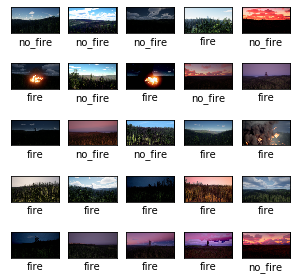

In [9]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = 5

    class_names = ['no_fire','fire']
    plt.figure(figsize=(5,5))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])

print('U5 Images: \n---------------')
plot_images(train_images, train_labels)

Test Real Images: 
---------------


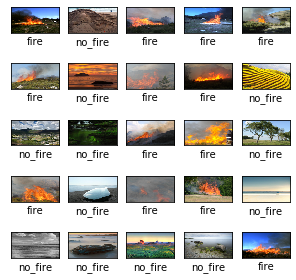

In [10]:
print('Test Real Images: \n---------------')
plot_images(test_data_images, test_data_labels)

In [22]:
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

,train_data_label,count_of_label
0,0,1307
1,1,1849


In [23]:
df = pd.DataFrame([label[0] for label in test_data_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['test_data_label', 'count_of_label']
df

,test_data_label,count_of_label
0,0,250
1,1,250


In [24]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]

In [106]:
input_shape

TensorShape([100, 186, 3])

In [108]:
len(train_images)

3156

# Image Agmentation and Sample Model 

In [117]:
train_predictions_baseline = model.predict(train_images)
test_predictions_baseline = model.predict(test_images)

In [153]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,50])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [115]:
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

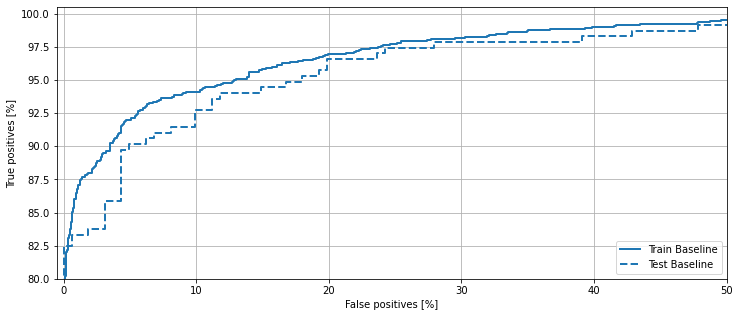

In [154]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [119]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

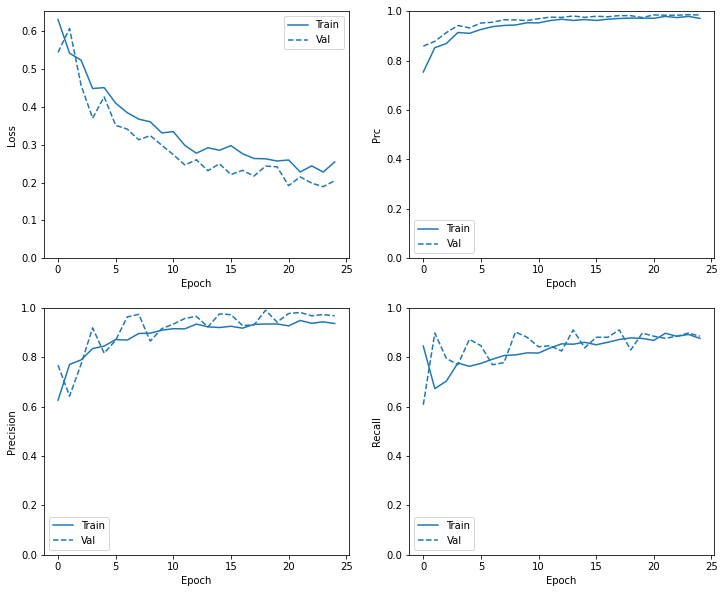

In [155]:
plot_metrics(history)

In [121]:
line_chart(history)

,epoch,variable,value
0,0,accuracy,0.611421
1,1,accuracy,0.693669
2,2,accuracy,0.714153
3,3,accuracy,0.779019
4,4,accuracy,0.777778


alt.Chart(...)

# Hyperparameter Tuning

In [11]:
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard
%reload_ext tensorboard
#! rm -rf ./logs/

In [33]:
session_num = 0
epochs = 10
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))#, 64])) #8, 16
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop']))#,'adam', 'Nadam'])) #'sgd','Adagrad'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
modelz = []

test_data_images, test_data_labels = zip(*test_data)

# epochs = 50
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'} 88/91
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'} 88/93
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 16, 'dropout': 0.2, 'optimizer': 'RMSprop'} 84/91

for num_units in HP_NUM_UNITS.domain.values:
    #for dropout_rate in HP_DROPOUT.domain.min_value:#, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        units.append(num_units)
        dropouts.append(dropout_rate)
        optimizers.append(optimizer)
        model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER,
                params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
                units, dropouts, optimizers, histories, augmentModel=True)
        modelz.append(model)
        session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'}
Epoch 1/10
99/99 [==============================] - 25s 240ms/step - loss: 0.7150 - accuracy: 0.6096 - f1_m: 0.7077 - precision_m: 0.5720 - recall_m: 0.9444
Epoch 2/10
99/99 [==============================] - 24s 239ms/step - loss: 0.5349 - accuracy: 0.7015 - f1_m: 0.7339 - precision_m: 0.5864 - recall_m: 0.9939
Epoch 3/10
99/99 [==============================] - 23s 235ms/step - loss: 0.4705 - accuracy: 0.7630 - f1_m: 0.7359 - precision_m: 0.5862 - recall_m: 0.9994
Epoch 4/10
99/99 [==============================] - 23s 237ms/step - loss: 0.4251 - accuracy: 0.8004 - f1_m: 0.7361 - precision_m: 0.5866 - recall_m: 0.9989
Epoch 5/10
99/99 [==============================] - 23s 237ms/step - loss: 0.3843 - accuracy: 0.8172 - f1_m: 0.7343 - precision_m: 0.5854 - recall_m: 0.9988
Epoch 6/10
99/99 [==============================] - 23s 235ms/step - loss: 0.3554 - accuracy: 0.8349 - f1_m: 0.7342 - precision_m: 

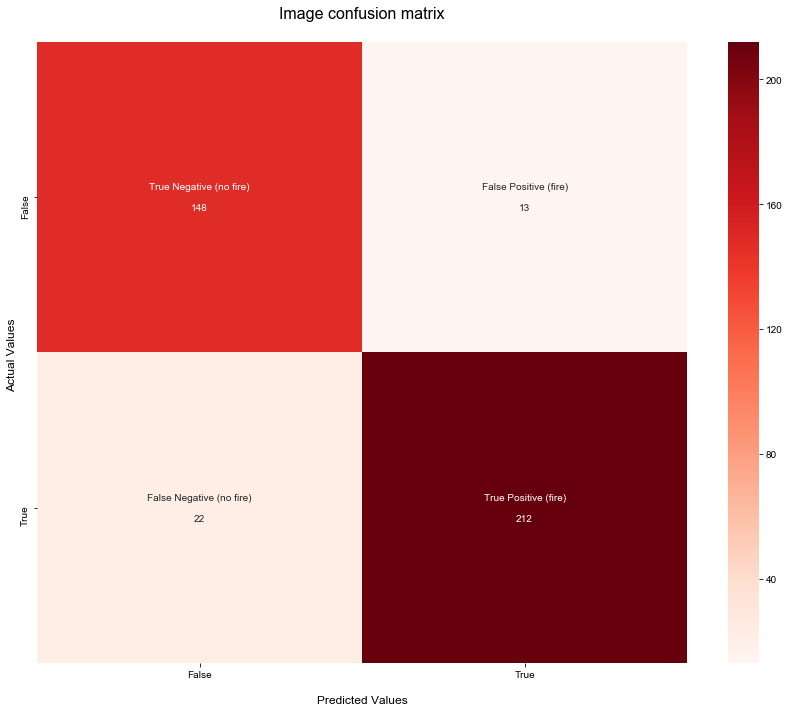

In [34]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, f1_scores, precisions, recalls, cms)),#aucs, 
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'f1_scores', 'precisions', 'recalls', 'cms'])#'aucs',

modelDf['cms'].values[0]

plot_confusion_matrix_2(modelDf['cms'].values[0],normalize=False)

In [35]:
line_chart(histories[0])

KeyError: "The following 'value_vars' are not present in the DataFrame: ['auc', 'precision', 'recall']"

In [ ]:

history_df = pd.DataFrame(histories[0].history).reset_index()
history_df

,index,loss,accuracy,f1_m,precision_m,recall_m
0,0,0.70714,0.550792,0.7145,0.568331,0.982416


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i in range(len(list(modelDf.optimizers))):
    cls = modelDf.iloc[i,2]
    plot_confusion_matrix_2(modelDf[modelDf['optimizers']==cls]['cms'][i])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()